In [13]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt

from growingline import *

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 

ogr.UseExceptions()

In [14]:
ds = None 


In [15]:
layer_name = "weiche"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp.gpkg"))

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['TEMPLINELAYER', 'abseits', 'anfang weiche', 'kurve', 'viele', 'weiche']


In [16]:
def new_line_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "centerlines"):
        delete_layer(ds, "centerlines", logger)
    layer = ds.CreateLayer("centerlines", spatial_reference, ogr.wkbLineString25D)
    return layer 


linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)

def linelayer_add(layer, geom):
    feature = ogr.Feature(layer.GetLayerDefn())
    feature.SetGeometry(geom)
    layer.CreateFeature(feature)


In [17]:
def get_all_points(layer):
    """Get all points from the layer as a list of numpy arrays"""
    points = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        for i in range(geom.GetPointCount()):
            point = np.array(geom.GetPoint(i)[:3])
            points.append(point)

    layer.ResetReading()
    return np.array(points)

In [18]:
queue = deque()

In [19]:
np.rad2deg(np.arccos(0.99))

np.float64(8.109614455994183)

## Start

In [20]:
all_points = get_all_points(layer)

In [21]:

layer.GetFeatureCount()

3882

In [22]:
feature = layer.GetNextFeature()
feature

OGRFeature(weiche):951
  eig x (Real) = 0.206159349714193
  eig y (Real) = -0.978518279550064
  eig z (Real) = -0.000546911147630067
  gauge (Real) = 1.44567067823869
  min points (Integer) = 300
  POINT Z (4473849.34625483 5336264.62714754 516.615297792815)


In [23]:
active_line = GrowingLine.from_feature(feature)


## Ab hier muss dann Schleife

In [286]:
xyz, distances, directions, gauges, fids = active_line.points_in_direction(layer)
print(len(xyz))

if len(xyz) < 3:
    not_finished = active_line.reverse_head()
    if not_finished is False:
        queue.extend(active_line.switch)
        print(len(queue), "in queue")
        active_line = queue.pop()

1
FINISHED
0 in queue


IndexError: pop from an empty deque

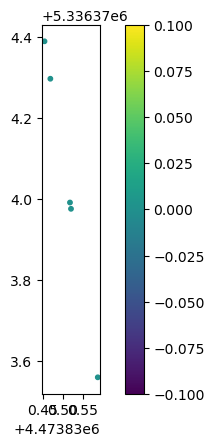

In [ ]:
labels = ransac_lines(xyz, threshold=0.05, max_iterations=20)

x = xyz[:, 0]
y = xyz[:, 1]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=labels, cmap='viridis', s=10)
plt.colorbar(sc)
#equal aspect ratio
ax.set_aspect('equal', adjustable='box')


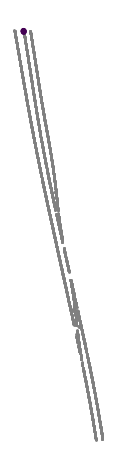

In [ ]:
fig, ax = plt.subplots()
ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1)
ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
fig.tight_layout()
fig.savefig("current_ransac_lines.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
# Check if we reached the end of a switch
if active_line.in_switch and labels.max() == 0:
    active_line.make_cut()
    if not active_line.reverse_head():
        # If we can't reverse the head, we are done
        print("Finished growing line")
        queue.extend(active_line.switch)
        print(len(queue), "in queue")
        active_line = queue.pop()

else:
    for label in range(labels.max()+1):
        cluster = xyz[labels == label]
        pruned, offset = pruned_points(cluster)
        fids_cluster = fids[labels == label]

        remove_points(fids_cluster[:offset+1], layer)
        
        new_direction = directions[offset]
        if active_line.head_direction @ new_direction < 0:
            new_direction = -new_direction

        
        
        if label == labels[0]:
            # This is the active head 
            active_line.head_xyz = pruned[-1]
            active_line.head_direction = new_direction
            active_line.head_gauge = gauges[offset]
            active_line.head_fid = fids_cluster[offset]
            active_line.points.extend(pruned) 
            print(len(pruned), "points added to active line")
        else:
            # This is the other rail in a switch (or false positive)
            active_line.add_switch(fids_cluster[offset], pruned[-1], new_direction, gauges[offset], pruned, fids_cluster[0])
            print(len(pruned), "points added to switch line")



2 points added to active line


In [ ]:
print("active line points:", len(active_line.points))
print("switch lines:", len(active_line.switch))
for i, switch in enumerate(active_line.switch):
    print(f"Switch line {i} points:", len(switch.points))

active line points: 322
switch lines: 0


In [ ]:
active_line.switch

[]

(5336076.440438583, 5336389.529898962)

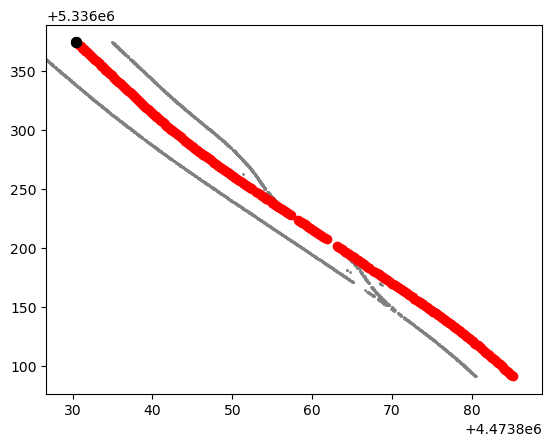

In [ ]:
fig, ax = plt.subplots()


active = np.array(active_line.points) 

ax.scatter(active[:, 0], active[:, 1], c='red')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')

colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, switch in enumerate(active_line.switch):
    points = np.array(switch.points)
    ax.scatter(points[:, 0], points[:, 1], c=colors[i % len(colors)])
    ax.scatter(switch.head_xyz[0], switch.head_xyz[1], c='black', s=30, label='Head')
    ax.scatter(switch.start_xyz[0], switch.start_xyz[1], c='white', s=5)

ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')


x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

x_lim = (x_lim[0] - 1, x_lim[1] + 1)
y_lim = (y_lim[0] - 1, y_lim[1] + 1)

ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1, zorder=0)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
#ax.set_aspect('equal', adjustable='box')

## STOP HERE

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
active_line.reverse_head()

FINISHED


False

In [ ]:
queue.extend(active_line.switch)
print(len(queue))
active_line = queue.pop()

2


In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    linelayer_add(linelayer, geom)


6.5373792594158795


In [ ]:
ds = None

In [ ]:
print(len(active_line.switch))

1


In [ ]:
active_line.points

[array([4.47384935e+06, 5.33626463e+06, 5.16615298e+02]),
 array([4.47384955e+06, 5.33626366e+06, 5.16617102e+02]),
 array([4.47384969e+06, 5.33626298e+06, 5.16619140e+02]),
 array([4.47384989e+06, 5.33626206e+06, 5.16621711e+02]),
 array([4.47385004e+06, 5.33626134e+06, 5.16624717e+02]),
 array([4.47385021e+06, 5.33626051e+06, 5.16628995e+02]),
 array([4.47385036e+06, 5.33625985e+06, 5.16633380e+02]),
 array([4.47385056e+06, 5.33625890e+06, 5.16641226e+02]),
 array([4.47385077e+06, 5.33625794e+06, 5.16648073e+02]),
 array([4.47385094e+06, 5.33625716e+06, 5.16652350e+02]),
 array([4.47385115e+06, 5.33625621e+06, 5.16657833e+02]),
 array([4.47385134e+06, 5.33625536e+06, 5.16661790e+02])]

In [ ]:
active_line.head_fid

1103

In [ ]:
active_line.head_xyz

array([4.47385134e+06, 5.33625536e+06, 5.16661790e+02])

In [ ]:
active_line.switch 

In [ ]:
active_line.switch[0].head_fid  

87372

In [ ]:
active_line.switch[1].head_fid  

87394

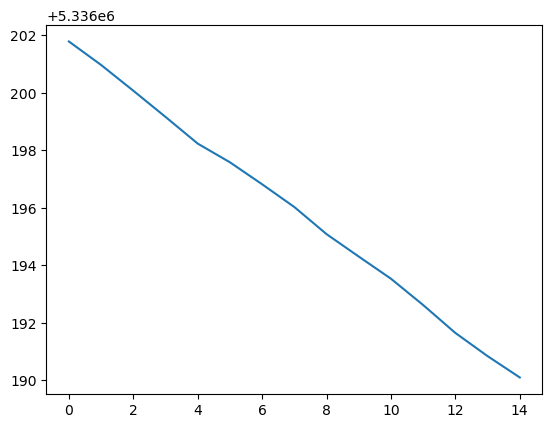

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

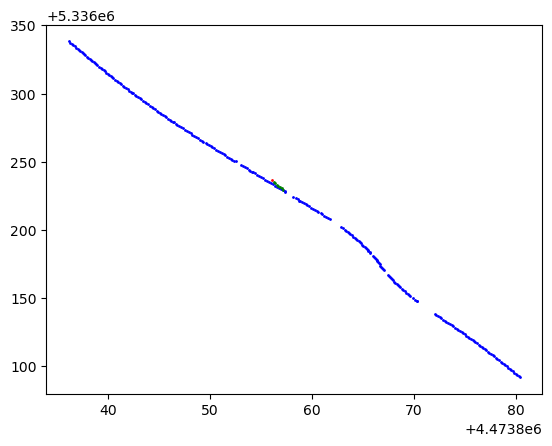

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

In [ ]:
remove_points([feature.GetFID()], layer)